In [2]:
# 加载云端硬盘
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Diffusion')
print(os.getcwd())
# 查看分配到的GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Diffusion
Mon Oct 16 12:19:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+---

In [3]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

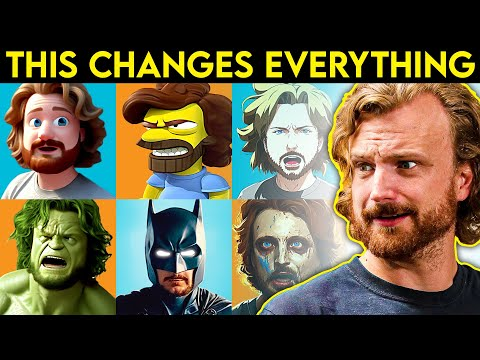

In [9]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

In [10]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/100 [00:00<?, ?it/s]

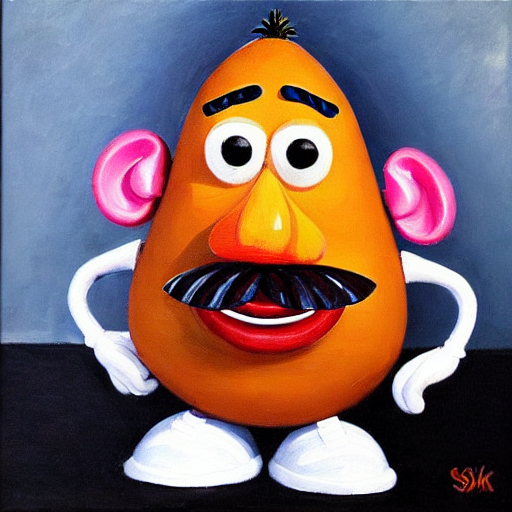

In [12]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=100, guidance_scale=7.5).images[0]
image

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

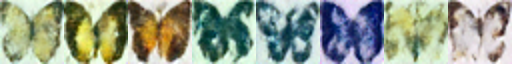

In [14]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

In [15]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

X shape: torch.Size([8, 3, 32, 32])


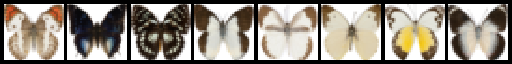

In [16]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [17]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

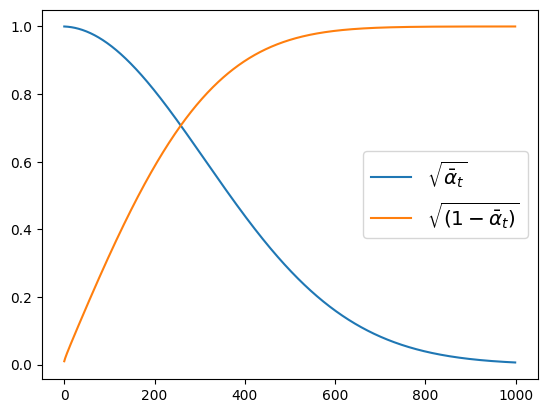

In [18]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 3, 32, 32])


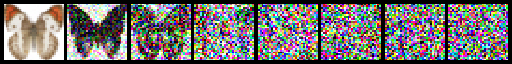

In [19]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [20]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [21]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [22]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.15217157872393727
Epoch:10, loss: 0.11598253482952714
Epoch:15, loss: 0.09549920028075576
Epoch:20, loss: 0.08925885427743196
Epoch:25, loss: 0.08100351737812161
Epoch:30, loss: 0.08114591962657869


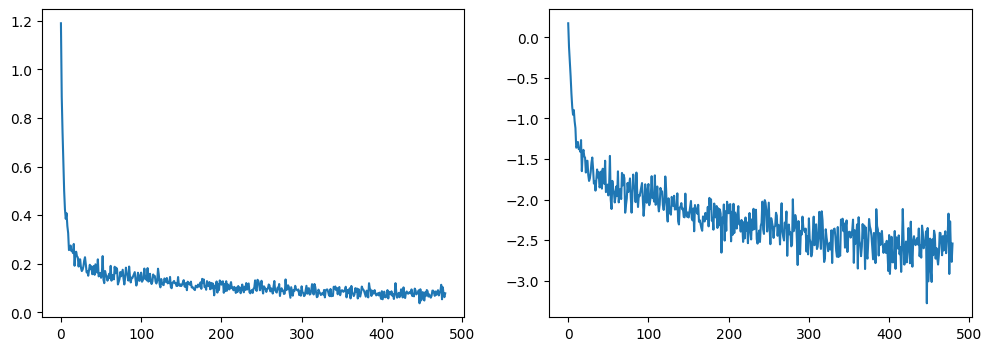

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

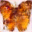

In [24]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

In [25]:
image_pipe.save_pretrained("my_pipeline")

In [26]:
!ls my_pipeline/

model_index.json  scheduler  unet


In [27]:
!pip install -q diffusers

In [28]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 24208871.82it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 120773373.70it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22199404.23it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23548243.22it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 6, 5, 3, 5, 4, 9, 7])


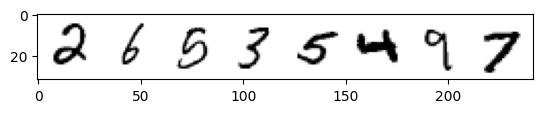

In [29]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

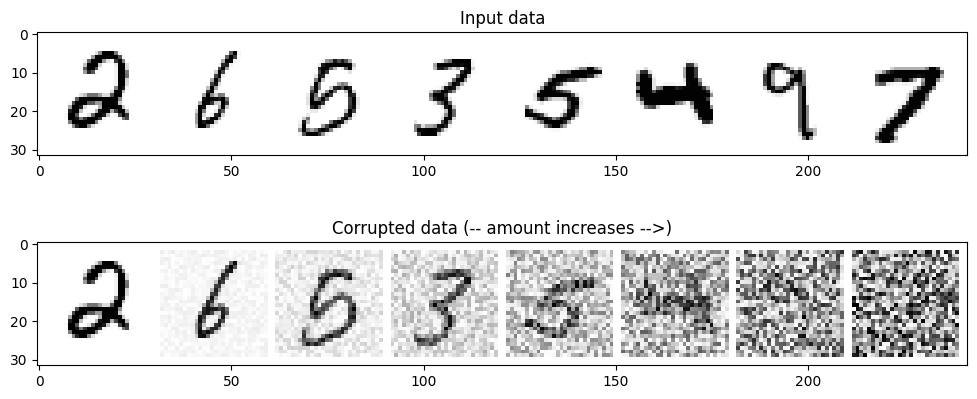

In [30]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plottinf the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

In [31]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [32]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.026668
Finished epoch 1. Average loss for this epoch: 0.020451
Finished epoch 2. Average loss for this epoch: 0.018767


(0.0, 0.1)

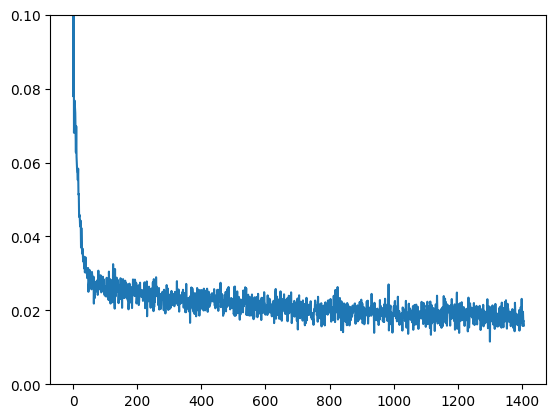

In [33]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

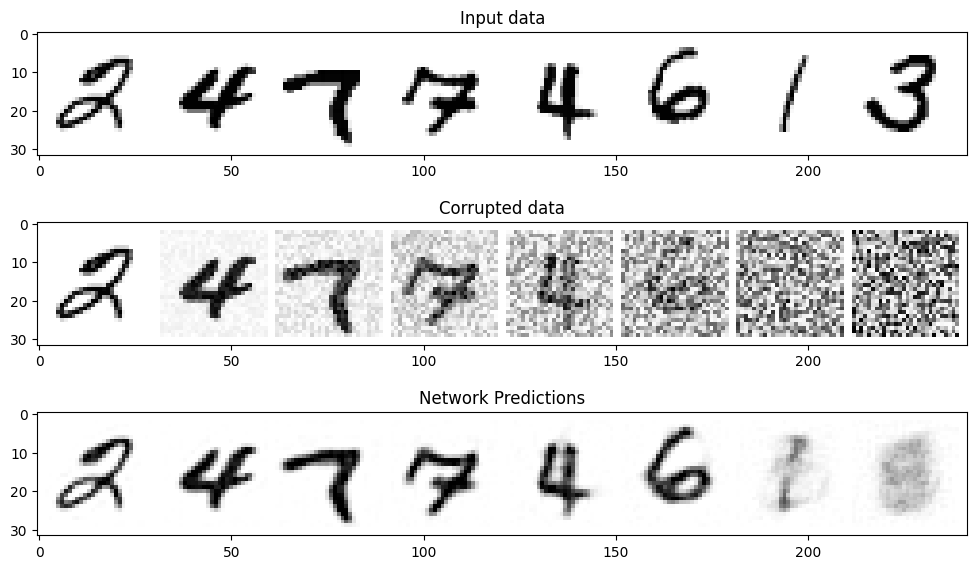

In [34]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

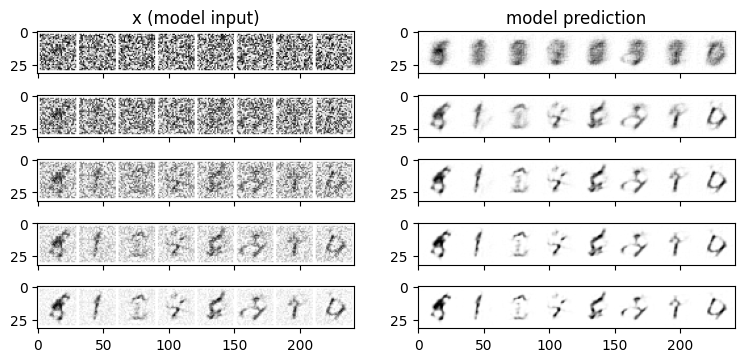

In [35]:

#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

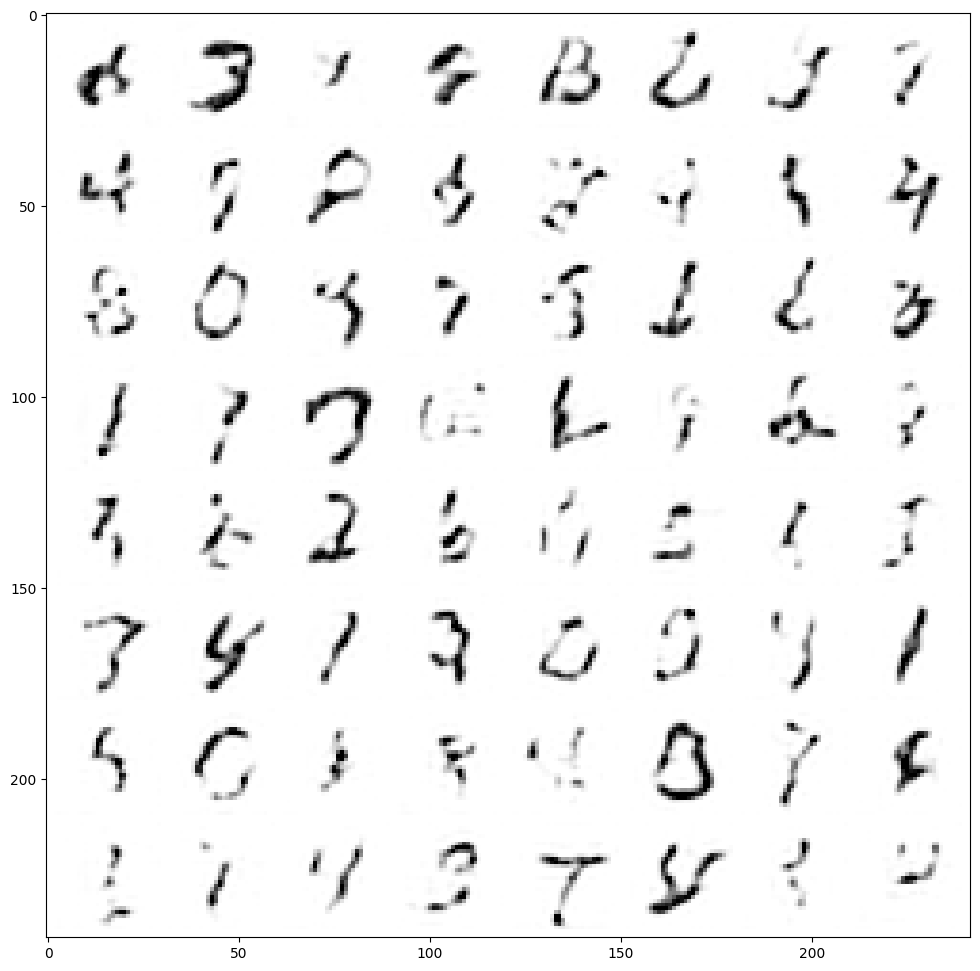

In [36]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

In [37]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)

Finished epoch 0. Average loss for this epoch: 0.019132
Finished epoch 1. Average loss for this epoch: 0.012798
Finished epoch 2. Average loss for this epoch: 0.011719


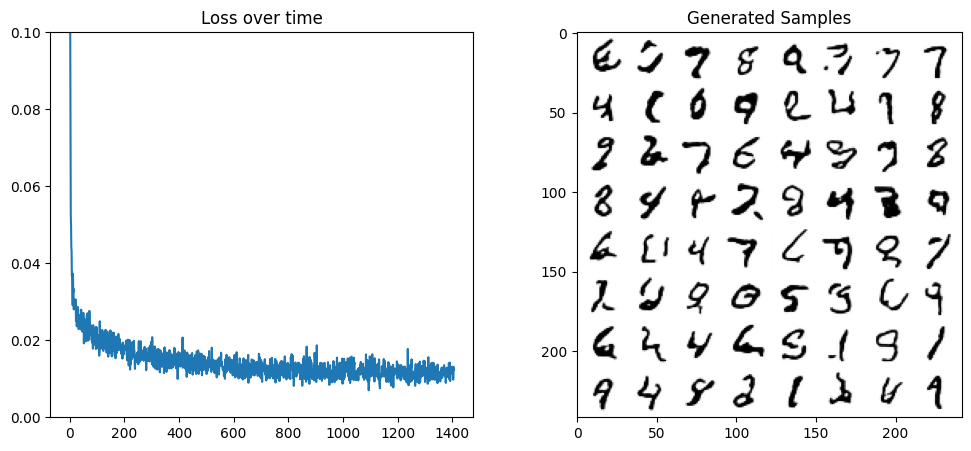

In [38]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


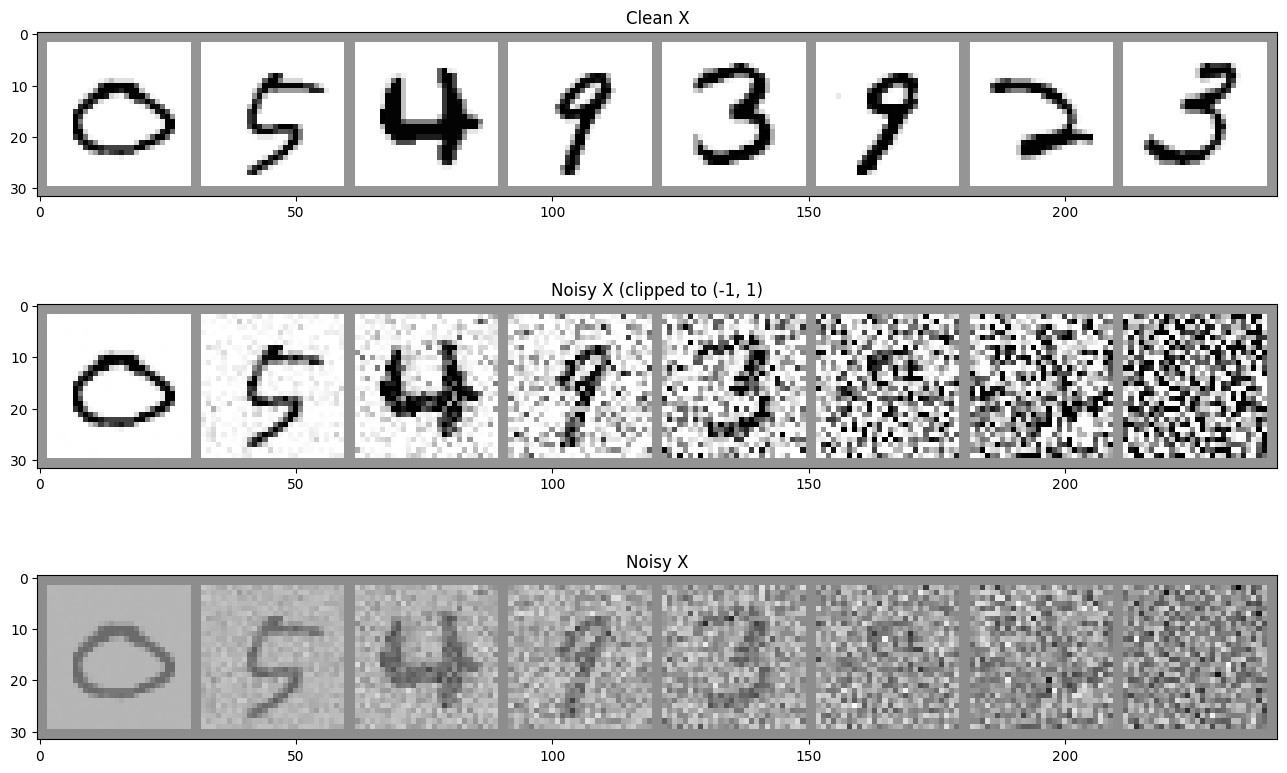

In [39]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');